In [1]:
import sys
sys.path.append('../src')

In [12]:
%load_ext autoreload
%autoreload 2

In [22]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, count
import pyspark.sql.functions as F

from data_preprocessing import convert_citibike_zip_to_parquet, load_parquet_in_spark

In [6]:
citibike_data_zip_path = '../data/raw/2023-citibike-tripdata.zip'
processed_data_output_path = '../data/processed/citibike/'

In [8]:
convert_citibike_zip_to_parquet(citibike_data_zip_path, processed_data_output_path)

C:\Users\azizt\Documents\case studies\Citibike_insurance_case_study\notebooks\../src\data_preprocessing.py:50: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  yield pd.read_csv(csv_file), csv_filename
C:\Users\azizt\Documents\case studies\Citibike_insurance_case_study\notebooks\../src\data_preprocessing.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stations = pd.concat([all_stations, new_stations])
C:\Users\azizt\Documents\case studies\Citibike_insurance_case_study\notebooks\../src\data_preprocessing.py:50: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  yield pd.read_csv(csv_file), csv_filename
C:\Users\azizt\Documents

In [19]:
trip_data = load_parquet_in_spark(os.path.join(processed_data_output_path,'trips/'))
print(f"Total number of records: {trip_data.count()}")

Total number of records: 35107030


In [23]:
# Filter out trips outside OF 2024 date range
trip_data = trip_data.withColumn("date", F.to_date("started_at"))
total_trips = trip_data.count()
trips_outside_range = trip_data.filter((F.col("date") < "2023-01-01") | (F.col("date") > "2023-12-31")).count()
percentage_outside_range = (trips_outside_range / (total_trips + trips_outside_range)) * 100
print(f"Number of trips outside the 2023-2024 range: {trips_outside_range} ({percentage_outside_range:.2f}%)")
print("We will discard these trips as we consider them outliers.")
trip_data = trip_data.filter((F.col("date") >= "2023-01-01") & (F.col("date") <= "2023-12-31"))

# Filter out trips with a duration shorter then 5 mins and longer than 300 mins
x_threshold = 300  # upper threshold
y_threshold = 5    # lower threshold
trip_data = trip_data.withColumn(
    "duration_minutes",
    F.round((F.unix_timestamp("ended_at") - F.unix_timestamp("started_at")) / 60).cast("integer")
)
total_trips = trip_data.count()
trips_longer_than_x = trip_data.filter(F.col("duration_minutes") > x_threshold).count()
trips_shorter_than_y = trip_data.filter(F.col("duration_minutes") < y_threshold).count()
percentage_longer_than_x = (trips_longer_than_x / total_trips) * 100
percentage_shorter_than_y = (trips_shorter_than_y / total_trips) * 100
print(f"Number of trips shorter than {y_threshold} minutes: {trips_shorter_than_y} ({percentage_shorter_than_y:.2f}%)")
print(f"Number of trips longer than {x_threshold} minutes: {trips_longer_than_x} ({percentage_longer_than_x:.2f}%)")
print("We will discard these trips as we consider them outliers.")
trip_data = trip_data.filter(
    (F.col("duration_minutes") >= y_threshold) & (F.col("duration_minutes") <= x_threshold)
)

Number of trips outside the 2023-2024 range: 320 (0.00%)
We will discard these trips as we consider them outliers.
Number of trips shorter than 5 minutes: 6663485 (18.98%)
Number of trips longer than 300 minutes: 63099 (0.18%)
We will discard these trips as we consider them outliers.


In [24]:
trip_data.show()

+-------------+-------------------+-------------------+----------------+--------------+-------------+----------+----------------+
|rideable_type|         started_at|           ended_at|start_station_id|end_station_id|member_casual|      date|duration_minutes|
+-------------+-------------------+-------------------+----------------+--------------+-------------+----------+----------------+
| classic_bike|2023-01-04 19:23:01|2023-01-04 19:34:57|         5391.06|       5626.13|       member|2023-01-04|              12|
| classic_bike|2023-01-20 09:22:19|2023-01-20 10:23:24|         4437.01|       4522.07|       member|2023-01-20|              61|
|electric_bike|2023-01-13 10:17:38|2023-01-13 10:33:59|         6955.05|       6039.06|       member|2023-01-13|              16|
| classic_bike|2023-01-26 19:17:23|2023-01-26 19:47:05|         7023.04|       5593.01|       member|2023-01-26|              30|
|electric_bike|2023-01-13 12:25:17|2023-01-13 12:38:53|         6955.05|       6039.06|   

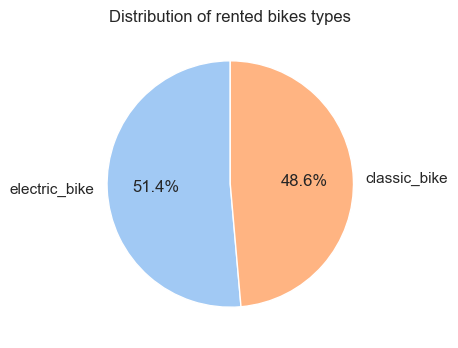

In [25]:
rideable_counts = trip_data.groupBy("rideable_type").count()
rideable_counts_pd = rideable_counts.toPandas()

sns.set_theme(style="ticks")
colors = sns.color_palette("pastel", 4)[:2]

plt.figure(figsize=(6, 4))
plt.pie(
    rideable_counts_pd['count'],
    labels=rideable_counts_pd['rideable_type'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Distribution of rented bikes types')
plt.show()

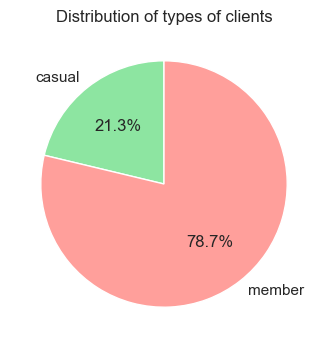

In [26]:
client_type_counts = trip_data.groupBy("member_casual").count()
client_type_counts_pd = client_type_counts.toPandas()

sns.set_theme(style="ticks")
colors = sns.color_palette("pastel", 4)[2:4]

plt.figure(figsize=(6, 4))
plt.pie(
    client_type_counts_pd['count'],
    labels=client_type_counts_pd['member_casual'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Distribution of types of clients')
plt.show()

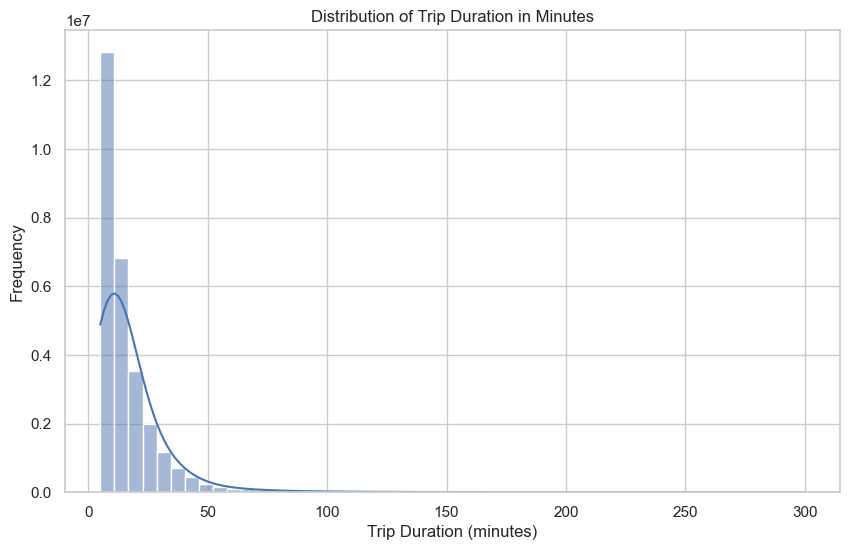

In [27]:
# Group by duration_minutes and get the count, then convert to Pandas
duration_counts = trip_data.groupBy("duration_minutes").count()
duration_counts_pd = duration_counts.toPandas()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=duration_counts_pd, x="duration_minutes", weights="count", bins=50, kde=True)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Duration in Minutes')
plt.show()

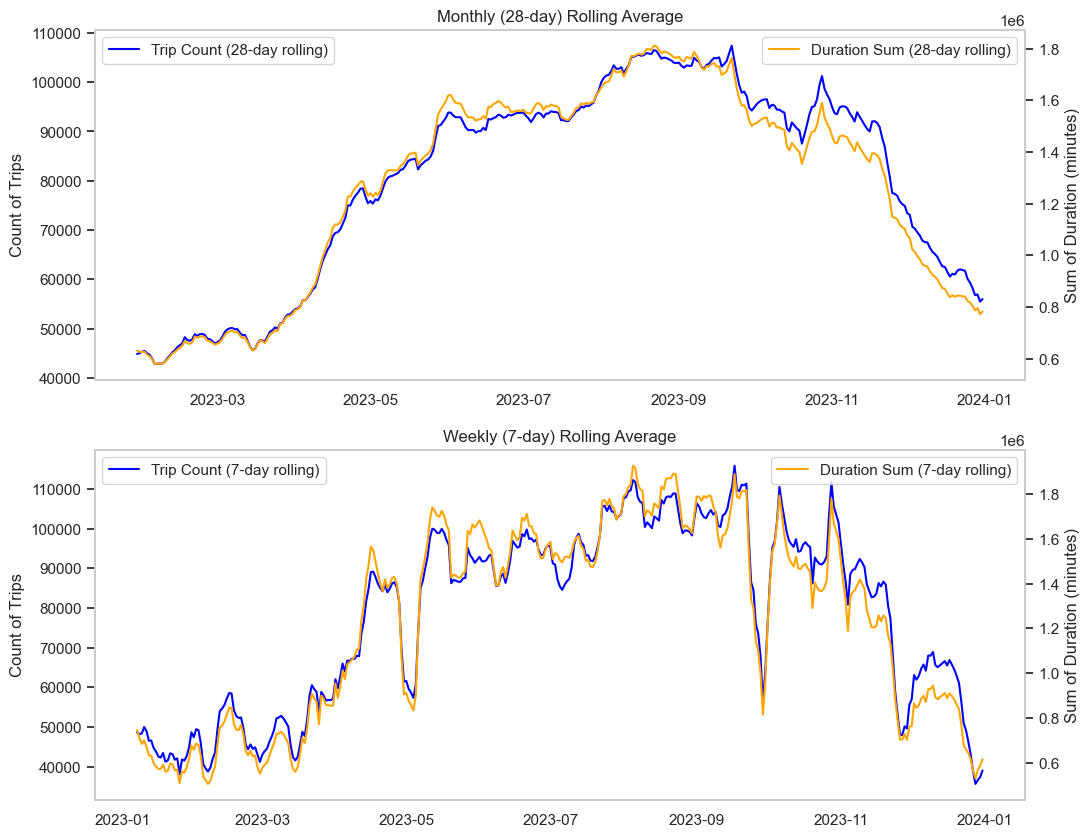

In [28]:
# Group by date and calculate daily trip count and duration sum
daily_data = trip_data.groupBy("date").agg(
    F.count("*").alias("trip_count"),
    F.sum("duration_minutes").alias("duration_sum")
)

# Convert to Pandas and set up for rolling averages
daily_data_pd = daily_data.orderBy("date").toPandas()
daily_data_pd['date'] = pd.to_datetime(daily_data_pd['date'])
daily_data_pd.set_index('date', inplace=True)

# Rolling averages for monthly (28 days) and weekly (7 days)
daily_data_pd['trip_count_rolling_28'] = daily_data_pd['trip_count'].rolling(window=28).mean()
daily_data_pd['duration_sum_rolling_28'] = daily_data_pd['duration_sum'].rolling(window=28).mean()
daily_data_pd['trip_count_rolling_7'] = daily_data_pd['trip_count'].rolling(window=7).mean()
daily_data_pd['duration_sum_rolling_7'] = daily_data_pd['duration_sum'].rolling(window=7).mean()

# plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot rolling monthly averages (28 days)
ax1 = axes[0]
ax1.plot(daily_data_pd.index, daily_data_pd['trip_count_rolling_28'], label='Trip Count (28-day rolling)', color='blue')
ax1.set_ylabel("Count of Trips")
#ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_title("Monthly (28-day) Rolling Average")
ax1.legend(loc='upper left')
ax1.grid(visible=False)

# Right y-axis for duration sum (28 days)
ax2 = ax1.twinx()
ax2.plot(daily_data_pd.index, daily_data_pd['duration_sum_rolling_28'], label='Duration Sum (28-day rolling)', color='orange')
ax2.set_ylabel("Sum of Duration (minutes)")
#ax2.tick_params(axis="y", labelcolor="orange")
ax2.legend(loc='upper right')
ax2.grid(visible=False)

# Plot rolling weekly averages (7 days)
ax3 = axes[1]
ax3.plot(daily_data_pd.index, daily_data_pd['trip_count_rolling_7'], label='Trip Count (7-day rolling)', color='blue')
ax3.set_ylabel("Count of Trips")
#ax3.tick_params(axis="y", labelcolor="blue")
ax3.set_title("Weekly (7-day) Rolling Average")
ax3.legend(loc='upper left')
ax3.grid(visible=False)

# Right y-axis for duration sum (7 days)
ax4 = ax3.twinx()
ax4.plot(daily_data_pd.index, daily_data_pd['duration_sum_rolling_7'], label='Duration Sum (7-day rolling)', color='orange')
ax4.set_ylabel("Sum of Duration (minutes)")
#ax4.tick_params(axis="y", labelcolor="orange")
ax4.legend(loc='upper right')
ax4.grid(visible=False)

# Show plot
#plt.xlabel("Date")
#plt.tight_layout()
plt.show()

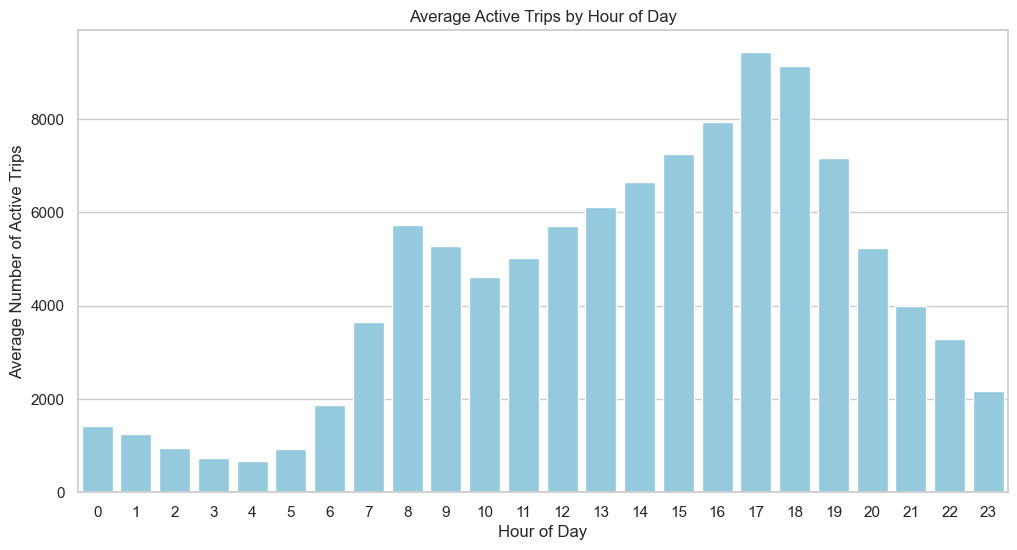

In [29]:
# Extract the start and end hours and date for each trip
trip_data = trip_data.withColumn("start_hour", F.hour("started_at"))
trip_data = trip_data.withColumn("end_hour", F.hour("ended_at"))
trip_data = trip_data.withColumn("start_date", F.to_date("started_at"))
trip_data = trip_data.withColumn("end_date", F.to_date("ended_at"))

# Expand trips to cover each hour they're active
expanded_trip_data = trip_data.select(
    "start_hour", "end_hour", "start_date", "end_date",
    F.expr("sequence(start_hour, end_hour)").alias("active_hours")
).withColumn("active_hour", F.explode("active_hours"))

# Adjust for trips that span into the next day
expanded_trip_data = expanded_trip_data.withColumn(
    "active_date", 
    F.when(F.col("active_hour") < F.col("start_hour"), F.date_add("start_date", 1)).otherwise(F.col("start_date"))
)

# Calculate average activity per hour
hourly_counts = expanded_trip_data.groupBy("active_hour").count()
total_days = expanded_trip_data.select("active_date").distinct().count()
hourly_counts = hourly_counts.withColumn("average_activity", F.col("count") / total_days)

# Convert to Pandas for plotting
hourly_counts_pd = hourly_counts.orderBy("active_hour").toPandas()

# Plotting the average activity by hour
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_counts_pd, x="active_hour", y="average_activity", color="skyblue")
plt.xlabel("Hour of Day")
plt.ylabel("Average Number of Active Trips")
plt.title("Average Active Trips by Hour of Day")
plt.xticks(range(0, 24))
plt.show()

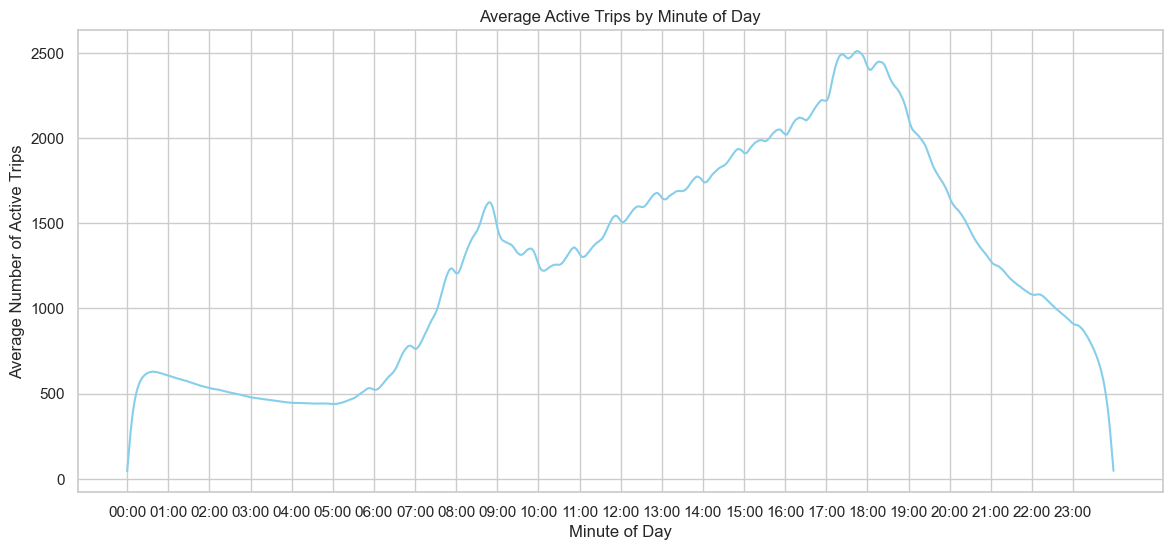

In [30]:
# Extract the start and end minute of the day as a single integer for each trip
trip_data = trip_data.withColumn("start_minute", (F.hour("started_at") * 60 + F.minute("started_at")))
trip_data = trip_data.withColumn("end_minute", (F.hour("ended_at") * 60 + F.minute("ended_at")))
trip_data = trip_data.withColumn("start_date", F.to_date("started_at"))
trip_data = trip_data.withColumn("end_date", F.to_date("ended_at"))

# Expand trips to cover each minute they're active
expanded_trip_data = trip_data.select(
    "start_minute", "end_minute", "start_date", "end_date",
    F.expr("sequence(start_minute, end_minute)").alias("active_minutes")
).withColumn("active_minute", F.explode("active_minutes"))

# Adjust for trips that span into the next day
expanded_trip_data = expanded_trip_data.withColumn(
    "active_date", 
    F.when(F.col("active_minute") < F.col("start_minute"), F.date_add("start_date", 1)).otherwise(F.col("start_date"))
)

# Calculate average activity per minute
minute_counts = expanded_trip_data.groupBy("active_minute").count()
total_days = expanded_trip_data.select("active_date").distinct().count()
minute_counts = minute_counts.withColumn("average_activity", F.col("count") / total_days)

# Convert to Pandas for plotting
minute_counts_pd = minute_counts.orderBy("active_minute").toPandas()

# Plotting the average activity by minute of day
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))
sns.lineplot(data=minute_counts_pd, x="active_minute", y="average_activity", color="skyblue")
plt.xlabel("Minute of Day")
plt.ylabel("Average Number of Active Trips")
plt.title("Average Active Trips by Minute of Day")
plt.xticks(ticks=range(0, 1440, 60), labels=[f"{h:02d}:00" for h in range(24)])  # Label each hour
plt.show()